In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import sklearn
from scipy.sparse import csr_matrix
import copy


In [3]:
# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ\Hao_Harmony_test_no_scale.h5ad")
adata = sc.read_h5ad(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')
adata.shape  # row is cells, column is gene

(161764, 33538)

In [3]:
type(adata.X)

scipy.sparse._csc.csc_matrix

In [4]:
# view adata.X
rows, cols = adata.X[:5,:].nonzero()
i = 0
for row, col in zip(rows, cols):
    if i == 20: break
    print(f'Row {row}, Column {col}, Value {adata.X[row, col]}')
    i += 1


Row 0, Column 12, Value 0.4895154535770416
Row 0, Column 43, Value 0.8167138695716858
Row 0, Column 48, Value 0.8167138695716858
Row 0, Column 53, Value 0.8167138695716858
Row 0, Column 55, Value 1.424944519996643
Row 0, Column 66, Value 0.4895154535770416
Row 0, Column 77, Value 0.8167138695716858
Row 0, Column 78, Value 1.424944519996643
Row 0, Column 89, Value 0.8167138695716858
Row 0, Column 93, Value 1.0628387928009033
Row 0, Column 102, Value 0.8167138695716858
Row 0, Column 154, Value 2.4626553058624268
Row 0, Column 178, Value 0.8167138695716858
Row 0, Column 185, Value 0.4895154535770416
Row 0, Column 190, Value 0.4895154535770416
Row 0, Column 201, Value 1.8004224300384521
Row 0, Column 224, Value 0.8167138695716858
Row 0, Column 240, Value 0.4895154535770416
Row 0, Column 259, Value 0.4895154535770416
Row 0, Column 261, Value 1.566353440284729


In [5]:
all_zero_cols = adata.X.getnnz(axis=0) == 0
zero_cols_count = np.sum(all_zero_cols)
print('No. of columns with all zeros:', zero_cols_count)  # 6034


No. of columns with all zeros: 6034


In [6]:
# Remove columns with all zeros
adata = adata[:, ~all_zero_cols]
print('New shape of adata.X:', adata.X.shape)
print('New shape of adata.var:', adata.var.shape)

New shape of adata.X: (161764, 27504)
New shape of adata.var: (27504, 0)


In [7]:
# All level 1 celltypes
adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(" ", "_")
adata.obs['celltype.l2'] = adata.obs['celltype.l2'].str.replace(" ", "_")
adata.obs['celltype.l3'] = adata.obs['celltype.l3'].str.replace(" ", "_")
types = np.unique(adata.obs['celltype.l2']).tolist()
print(types)
# cell count in each celltype
adata.obs['celltype.l2'].value_counts()

C:\Users\evanlee\AppData\Local\Temp\ipykernel_72072\2460788363.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(" ", "_")


['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']


celltype.l2
CD14_Mono            42690
CD4_Naive            17479
NK                   17173
CD4_TCM              14889
CD8_TEM              11727
CD8_Naive            10768
B_naive               7718
CD16_Mono             6320
CD4_TEM               4282
gdT                   3649
B_memory              3285
CD8_TCM               2883
MAIT                  2784
Treg                  2507
cDC2                  2501
B_intermediate        2431
Platelet              2293
CD4_CTL               1736
NK_CD56bright          943
pDC                    861
Doublet                605
NK_Proliferating       548
Plasmablast            366
dnT                    356
HSPC                   329
cDC1                   151
ILC                    132
CD4_Proliferating      108
CD8_Proliferating       91
Eryth                   83
ASDC                    76
Name: count, dtype: int64

In [8]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14_Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4
L1_AAACCCAAGACATACA,CD4_T,CD4_TCM,CD4_TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2
L1_AAACCCACAACTGGTT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3
L1_AAACCCACAGCATACT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5


## UMAP with stored embedding in Hao_PBMC_scaled_Harmony.h5ad

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

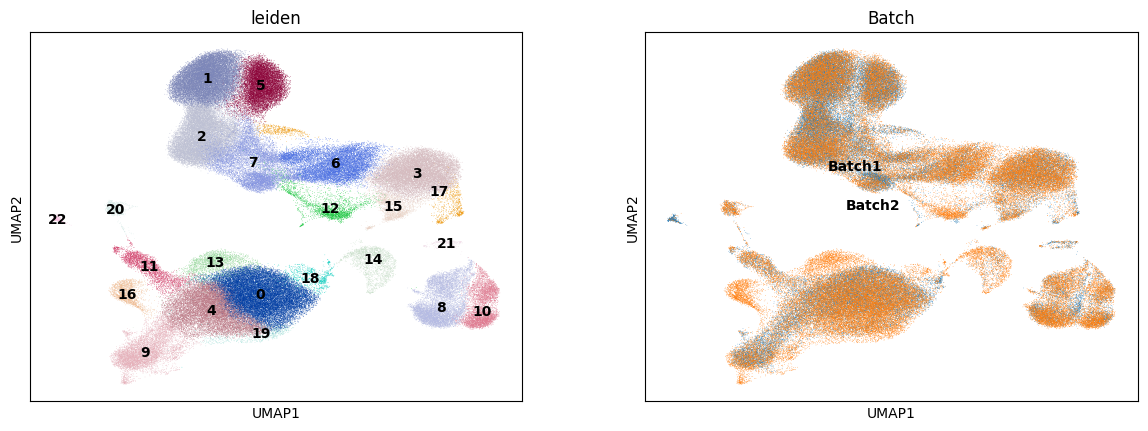

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_

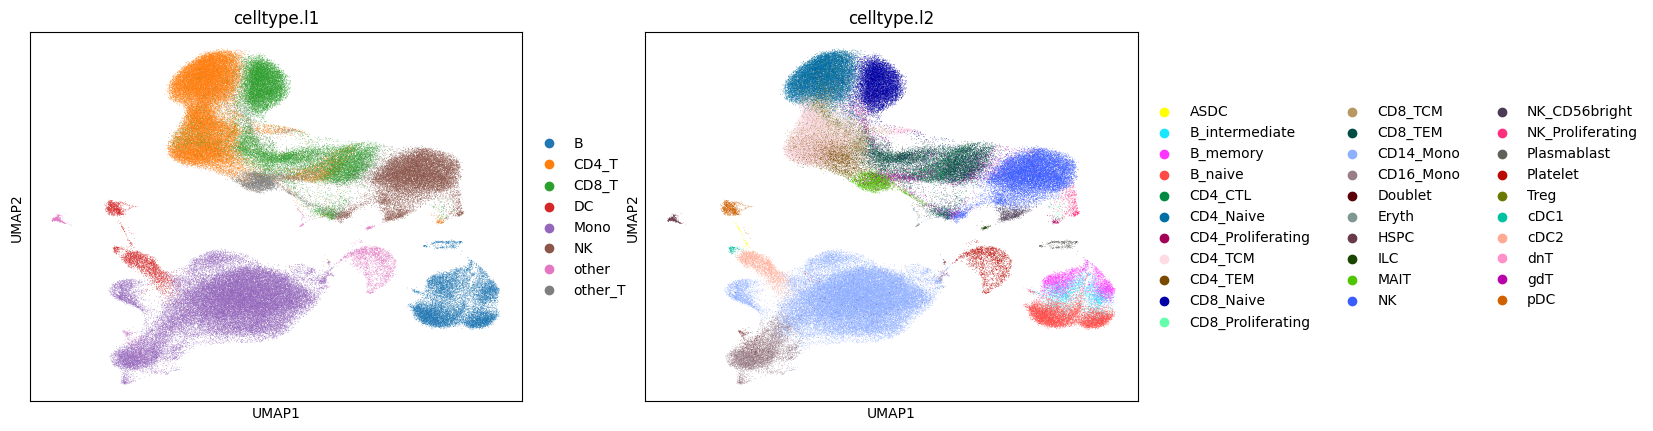

In [9]:
sc.pl.umap(adata, color=['leiden', 'Batch'], legend_loc="on data")
sc.pl.umap(adata, color=['celltype.l1', 'celltype.l2'], legend_loc="right margin")

## Representative cells
Select top clustering coefficient cells in each cell type <br>
According to the inverse relationshiop between "celltype cell count" and "Percentage" <br>
Detailed in Excel file <br>

In [10]:
umap_adja_matrix = adata.obsp['connectivities']  # derived from sc.pp.neighbors()
umap_adja_matrix

<161764x161764 sparse matrix of type '<class 'numpy.float32'>'
	with 3703678 stored elements in Compressed Sparse Row format>

In [11]:
# briefly view adjacency matrix
rows, cols = umap_adja_matrix[:5,:].nonzero()
i = 0
for row, col in zip(rows, cols):
    if i == 20: break
    print(f'Row {row}, Column {col}, Value {umap_adja_matrix[row, col]}')
    i += 1

Row 0, Column 1028, Value 0.070370614528656
Row 0, Column 5671, Value 0.09094648063182831
Row 0, Column 18442, Value 0.15894591808319092
Row 0, Column 22705, Value 0.191518634557724
Row 0, Column 23916, Value 0.12592612206935883
Row 0, Column 25787, Value 0.12485816329717636
Row 0, Column 25857, Value 0.23459471762180328
Row 0, Column 26029, Value 0.1444644033908844
Row 0, Column 35636, Value 0.11799775063991547
Row 0, Column 35796, Value 0.16523410379886627
Row 0, Column 40189, Value 0.3428487777709961
Row 0, Column 55684, Value 0.31770333647727966
Row 0, Column 56309, Value 0.11555074155330658
Row 0, Column 58269, Value 0.2235662341117859
Row 0, Column 60340, Value 0.15252311527729034
Row 0, Column 64842, Value 0.9033235311508179
Row 0, Column 71137, Value 0.17671233415603638
Row 0, Column 87821, Value 0.16186591982841492
Row 0, Column 103106, Value 1.0
Row 0, Column 108852, Value 1.0


In [13]:
# Turn adjacency matrix to binary
binary_adj_mat = umap_adja_matrix.copy()
binary_adj_mat.data = np.ones_like(binary_adj_mat.data).astype(int)

rows, cols = binary_adj_mat[:5,:].nonzero()
i = 0
for row, col in zip(rows, cols):
    if i == 20: break
    print(f'Row {row}, Column {col}, Value {binary_adj_mat[row, col]}')
    i += 1

Row 0, Column 1028, Value 1
Row 0, Column 5671, Value 1
Row 0, Column 18442, Value 1
Row 0, Column 22705, Value 1
Row 0, Column 23916, Value 1
Row 0, Column 25787, Value 1
Row 0, Column 25857, Value 1
Row 0, Column 26029, Value 1
Row 0, Column 35636, Value 1
Row 0, Column 35796, Value 1
Row 0, Column 40189, Value 1
Row 0, Column 55684, Value 1
Row 0, Column 56309, Value 1
Row 0, Column 58269, Value 1
Row 0, Column 60340, Value 1
Row 0, Column 64842, Value 1
Row 0, Column 71137, Value 1
Row 0, Column 87821, Value 1
Row 0, Column 103106, Value 1
Row 0, Column 108852, Value 1


In [14]:
# Clustering coefficient
import networkx as nx

G = nx.from_scipy_sparse_array(binary_adj_mat)
print(G)

clustering_coeff = nx.clustering(G)
print(len(clustering_coeff))

Graph with 161764 nodes and 1851839 edges
161764


In [15]:
# Get the first 10 keys and values of the dictionary
first_10_items = list(clustering_coeff.items())[:10]

# Print the first 10 keys and values
for key, value in first_10_items:
    print(f"Key: {key}, Value: {value}")

# Keys are cell index, values are the corresponding clustering coefficient

Key: 0, Value: 0.13157894736842105
Key: 1, Value: 0.1323529411764706
Key: 2, Value: 0.17582417582417584
Key: 3, Value: 0.10476190476190476
Key: 4, Value: 0.11052631578947368
Key: 5, Value: 0.17647058823529413
Key: 6, Value: 0.13333333333333333
Key: 7, Value: 0.13333333333333333
Key: 8, Value: 0.13725490196078433
Key: 9, Value: 0.09523809523809523


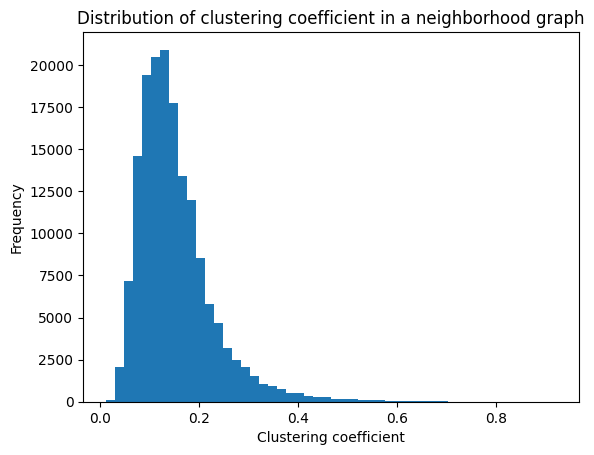

In [16]:
# Plot the distribution of clustering coefficients
import matplotlib.pyplot as plt
coefs = list(clustering_coeff.values())
plt.title('Distribution of clustering coefficient in a neighborhood graph')
plt.hist(coefs, bins=50)
plt.xlabel('Clustering coefficient')
plt.ylabel('Frequency')
plt.show()


In [4]:
# selection criteria
# inv_percentage = pd.read_csv(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\L2_log(count)_inv_percentage.csv", index_col=0)
inv_percentage = pd.read_csv(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/L2_log(count)_inv_percentage.csv', index_col=0)
inv_percentage

,Original count,log10(count),Percentage,Selected count
CD14_Mono,42690,4.630326,0.200000,8538
CD4_Naive,17479,4.242517,0.312837,5469
NK,17173,4.234846,0.315069,5411
CD4_TCM,14889,4.172866,0.333103,4960
CD8_TEM,11727,4.069187,0.363269,4261
CD8_Naive,10768,4.032135,0.374050,4028
B_naive,7718,3.887505,0.416132,3212
CD16_Mono,6320,3.800717,0.441384,2790
CD4_TEM,4282,3.631647,0.490576,2101
gdT,3649,3.562174,0.510790,1864


In [19]:
import math
# Select top percentage clustering coefficient cells in each cell type
alltype_selected = dict()

for celltype in types:
    print('====================')
    # get percentage
    percentage = inv_percentage.loc[celltype, 'Percentage']
    print(celltype, percentage)

    # select cells from one celltype
    celltype_idx = np.where(adata.obs['celltype.l2'] == celltype)[0]
    celltype_coeff = {node_idx: clustering_coeff[node_idx] for node_idx in celltype_idx}
    
    top_count = math.ceil(len(celltype_coeff) * percentage)
    print('top count', top_count)
    top_indices = sorted(celltype_coeff, key=celltype_coeff.get, reverse=True)[:top_count]  # sort celltype_coeff by value (descending)
    # print(top_indices)
    celltype_selected = {node_idx: celltype_coeff[node_idx] for node_idx in top_indices}
    # print(celltype_selected)
    alltype_selected.update(celltype_selected)
    print(celltype, len(celltype_selected))


ASDC 1.0
top count 76
ASDC 76
B_intermediate 0.562112532
top count 1367
B_intermediate 1367
B_memory 0.524069305
top count 1722
B_memory 1722
B_naive 0.416131802
top count 3212
B_naive 3212
CD14_Mono 0.2
top count 8538
CD14_Mono 8538
CD16_Mono 0.441383608
top count 2790
CD16_Mono 2790
CD4_CTL 0.604661234
top count 1050
CD4_CTL 1050
CD4_Naive 0.312837331
top count 5469
CD4_Naive 5469
CD4_Proliferating 0.955596446
top count 104
CD4_Proliferating 104
CD4_TCM 0.333103047
top count 4960
CD4_TCM 4960
CD4_TEM 0.490576448
top count 2101
CD4_TEM 2101
CD8_Naive 0.374050082
top count 4028
CD8_Naive 4028
CD8_Proliferating 0.977238787
top count 89
CD8_Proliferating 89
CD8_TCM 0.540564078
top count 1559
CD8_TCM 1559
CD8_TEM 0.363269443
top count 4261
CD8_TEM 4261
Doublet 0.737861381
top count 447
Doublet 447
Eryth 0.988866536
top count 83
Eryth 83
HSPC 0.814837782
top count 269
HSPC 269
ILC 0.930239173
top count 123
ILC 123
MAIT 0.544979525
top count 1518
MAIT 1518
NK 0.315069119
top count 5411
NK 5

In [20]:
len(alltype_selected)

57515

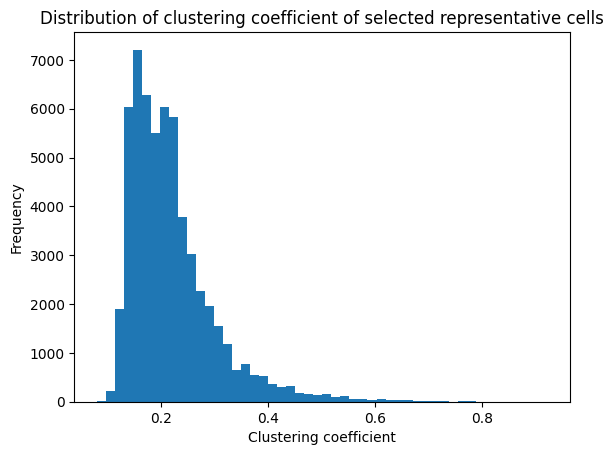

In [21]:
# Plot the distribution of clustering coefficients of selected representative cells
import matplotlib.pyplot as plt
coefs = list(alltype_selected.values())
plt.title('Distribution of clustering coefficient of selected representative cells')
plt.hist(coefs, bins=50)
plt.xlabel('Clustering coefficient')
plt.ylabel('Frequency')
plt.show()


In [22]:
# add column to adata.obs
is_representative = ['Yes' if cell in alltype_selected.keys() else 'No' for cell in clustering_coeff.keys()]
is_representative = np.array(is_representative)

# Add is_representative (Yes or No) to data.obs
adata.obs['is_representative'] = is_representative
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden,is_representative
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14_Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4,No
L1_AAACCCAAGACATACA,CD4_T,CD4_TCM,CD4_TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2,No
L1_AAACCCACAACTGGTT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5,Yes
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3,No
L1_AAACCCACAGCATACT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5,No


In [23]:
sum(adata.obs['is_representative'] == 'Yes')

57515

In [24]:
# Add a column: Cluster_representative
# 在 representative cell 中，加上 cluster
clus_rep = []
for i in range(adata.shape[0]):
    if adata.obs['is_representative'][i] == 'Yes':
        # Yes_cluster_name
        clus_rep.append(adata.obs['is_representative'][i] + '_' + adata.obs['celltype.l2'][i])
    else:
        # No
        clus_rep.append(adata.obs['is_representative'][i])

adata.obs['cluster_representative'] = clus_rep

C:\Users\evanlee\AppData\Local\Temp\ipykernel_72072\2774745940.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata.obs['is_representative'][i] == 'Yes':
C:\Users\evanlee\AppData\Local\Temp\ipykernel_72072\2774745940.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  clus_rep.append(adata.obs['is_representative'][i])
C:\Users\evanlee\AppData\Local\Temp\ipykernel_72072\2774745940.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[

In [25]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden,is_representative,cluster_representative
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14_Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4,No,No
L1_AAACCCAAGACATACA,CD4_T,CD4_TCM,CD4_TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2,No,No
L1_AAACCCACAACTGGTT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5,Yes,Yes_CD8_Naive
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3,No,No
L1_AAACCCACAGCATACT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5,No,No


## Plot representative cell UMAP

In [26]:
### Get palette
# Get cell counts for each cell type
l1_cell_counts = adata.obs['celltype.l1'].value_counts()  # in value order 
l2_cell_counts = adata.obs['celltype.l2'].value_counts()

# Get colors from sc.pl.umap() plot
l1_colors = adata.uns['celltype.l1_colors']  # in celltype alphabet order
l2_colors = adata.uns['celltype.l2_colors']
# map cell type names to colors
l1_cmap = dict(zip(l1_cell_counts.index.sort_values(), l1_colors))  # in alphabet order
l2_cmap = dict(zip(l2_cell_counts.index.sort_values(), l2_colors))

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


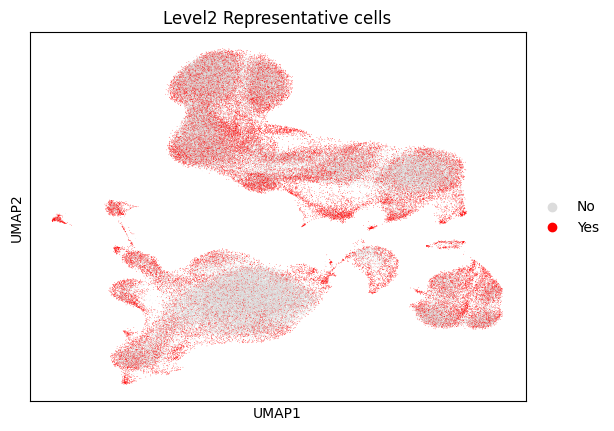

In [27]:
# Plot Yes/No representative cells
sc.pl.umap(adata, color='is_representative', title='Level2 Representative cells', palette=['#dcdcdc', 'red'])

c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


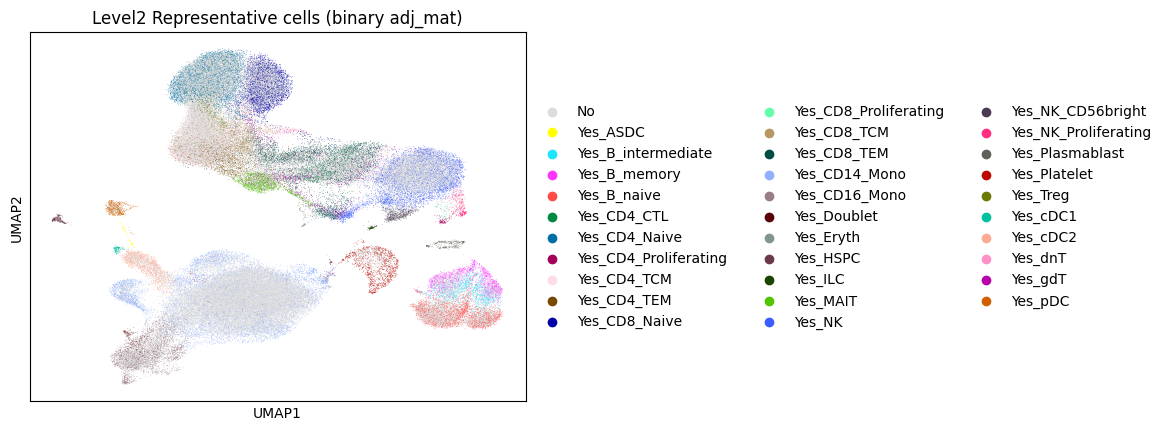

In [29]:
# Also differentiating representative cells from different cell types
sc.pl.umap(adata, color='cluster_representative', title='Level2 Representative cells (binary adj_mat)', palette=['#dcdcdc']+l2_colors.tolist())

## Export representative cells adata

In [ ]:
adata_rep_cells = adata[adata.obs['is_representative'] == 'Yes']
adata_rep_cells.shape

In [5]:
# os.chdir(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ")
os.chdir(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ')

In [ ]:
adata_rep_cells.obs.head()

In [ ]:
# Briefly view adata.X (raw counts)
rows, cols = adata_rep_cells.X[:5,:].nonzero()
i = 0
for row, col in zip(rows, cols):
    if i == 20: break
    print(f'Row {row}, Column {col}, Value {adata_rep_cells.X[row, col]}')
    i += 1


In [30]:
# adata_rep_cells.write_h5ad('Hao_L2_repcells_loginv_Harmony_noZ.h5ad')

In [ ]:
np.unique(adata_rep_cells.obs['celltype.l2']).tolist()

## Heatmap of clustering coefficient

In [36]:
adata.obs['clus_coeff_binary'] = clustering_coeff.values()

In [37]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden,is_representative,cluster_representative,clus_coeff_binary
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14_Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4,No,No,0.131579
L1_AAACCCAAGACATACA,CD4_T,CD4_TCM,CD4_TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2,No,No,0.132353
L1_AAACCCACAACTGGTT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5,Yes,Yes_CD8_Naive,0.175824
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3,No,No,0.104762
L1_AAACCCACAGCATACT,CD8_T,CD8_Naive,CD8_Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5,No,No,0.110526


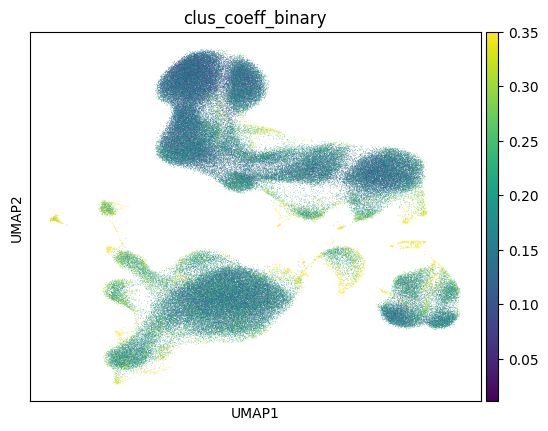

In [42]:
sc.pl.umap(adata, color='clus_coeff_binary', vmax=0.35)